### Features

**datetime** - hourly date + timestamp

**season** - season of the year (1 = spring, 2 = summer, 3 = fall, 4 = winter)

**holiday** - whether the day is considered a holiday (1: holiday, 0: not a holiday)

**workingday** - whether the day is neither a weekend nor holiday (1: working day, 0: not a working day)

**weather**:

1: Clear, Few clouds, Partly cloudy, Partly cloudy

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated

**registered** - number of registered user rentals initiated

**count** - number of total rentals

In [65]:
# General Libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Preprocessing:
from sklearn.model_selection import train_test_split

# Model:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sklearn
from sklearn.model_selection import cross_val_score

In [87]:
# Creating relevant variables
rs = 42 #Random_state
np.random.seed(rs)
cv = 5
%matplotlib inline
plt.rcParams['figure.figsize'] = [40, 40]

In [3]:
# Relevant Functions

# Function to detect and print outliers 
def detect_outliers(data):
    # mean, standard deviation and 3-sigma of the data
    mean = np.mean(data)
    std = np.std(data)
    threesigma = 3 * std
    
    # print upper, lower boundary and boxplot
    sns.boxplot(data, orient="v")
    plt.show()
    lower, upper = mean-3*std, mean+3*std
    print(f"Upper and lower boundary is: {lower}/{upper}")
    
    # identify outliers and return the outliers
    outliers = [x for x in data if np.abs(x - mean) > threesigma]
    print(f"There are {len(outliers)} outliers based on three-sigma rule")

# Function to delete the outliers 
def delete_outliers(data, df):
    # detecting and dropping outliers 
    original_shape = df.shape
    mean = np.mean(data)
    std = np.std(data)
    outliers = np.abs(data-mean) > (3*std)
    outliers_num = len(df[outliers])
    df.drop(index=data[outliers].index, inplace=True)
    
    # print what was deleted
    print("Number of outliers deleted:", outliers_num)
    print ("Shape of dataframe with Ouliers: ",original_shape)
    print ("Shape of Dataframe After Deleting the Ouliers: ",df.shape)

# Function to plot the Correlation Heatmap
def correlation_heatmap(corr):
    mask = np.array(corr)
    mask[np.tril_indices_from(mask)] = False
    
    # plot the correlation
    fig,ax= plt.subplots()
    fig.set_size_inches(10,10)
    sns.heatmap(corr, mask=mask,vmax=.8, square=True,annot=True)

# Function to calculate RMSLE - Root Mean Squared Logarithmic Error   
def rmsle(y_true, y_pred):
    """
    Custom RMSLE scorer function.
    """
    log_diff = np.log1p(y_pred) - np.log1p(y_true)
    rmsle_score = np.sqrt(np.mean(log_diff**2))
    return rmsle_score

In [4]:
#Loading the data:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Understanding the Dataset

In [5]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
#Transforming our datetime column into a datetime type:
# For df
df['datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['datetime']]

# For df_test:
df_test['datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df_test['datetime']]

In [8]:
#Creating the hour column to better vizualize the count in correlation with the day

#For train:
df['hour'] = df['datetime'].dt.hour
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.weekday

# For test:
df_test['hour'] = df_test['datetime'].dt.hour
df_test['year'] = df_test['datetime'].dt.year
df_test['month'] = df_test['datetime'].dt.month
df_test['weekday'] = df_test['datetime'].dt.weekday

In [9]:
df.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year,month,weekday
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,2011.501929,6.521495,3.013963
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2011.000000,1.000000,0.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,2011.000000,4.000000,1.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,2012.000000,7.000000,3.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,2012.000000,10.000000,5.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,2012.000000,12.000000,6.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,0.500019,3.444373,2.004585


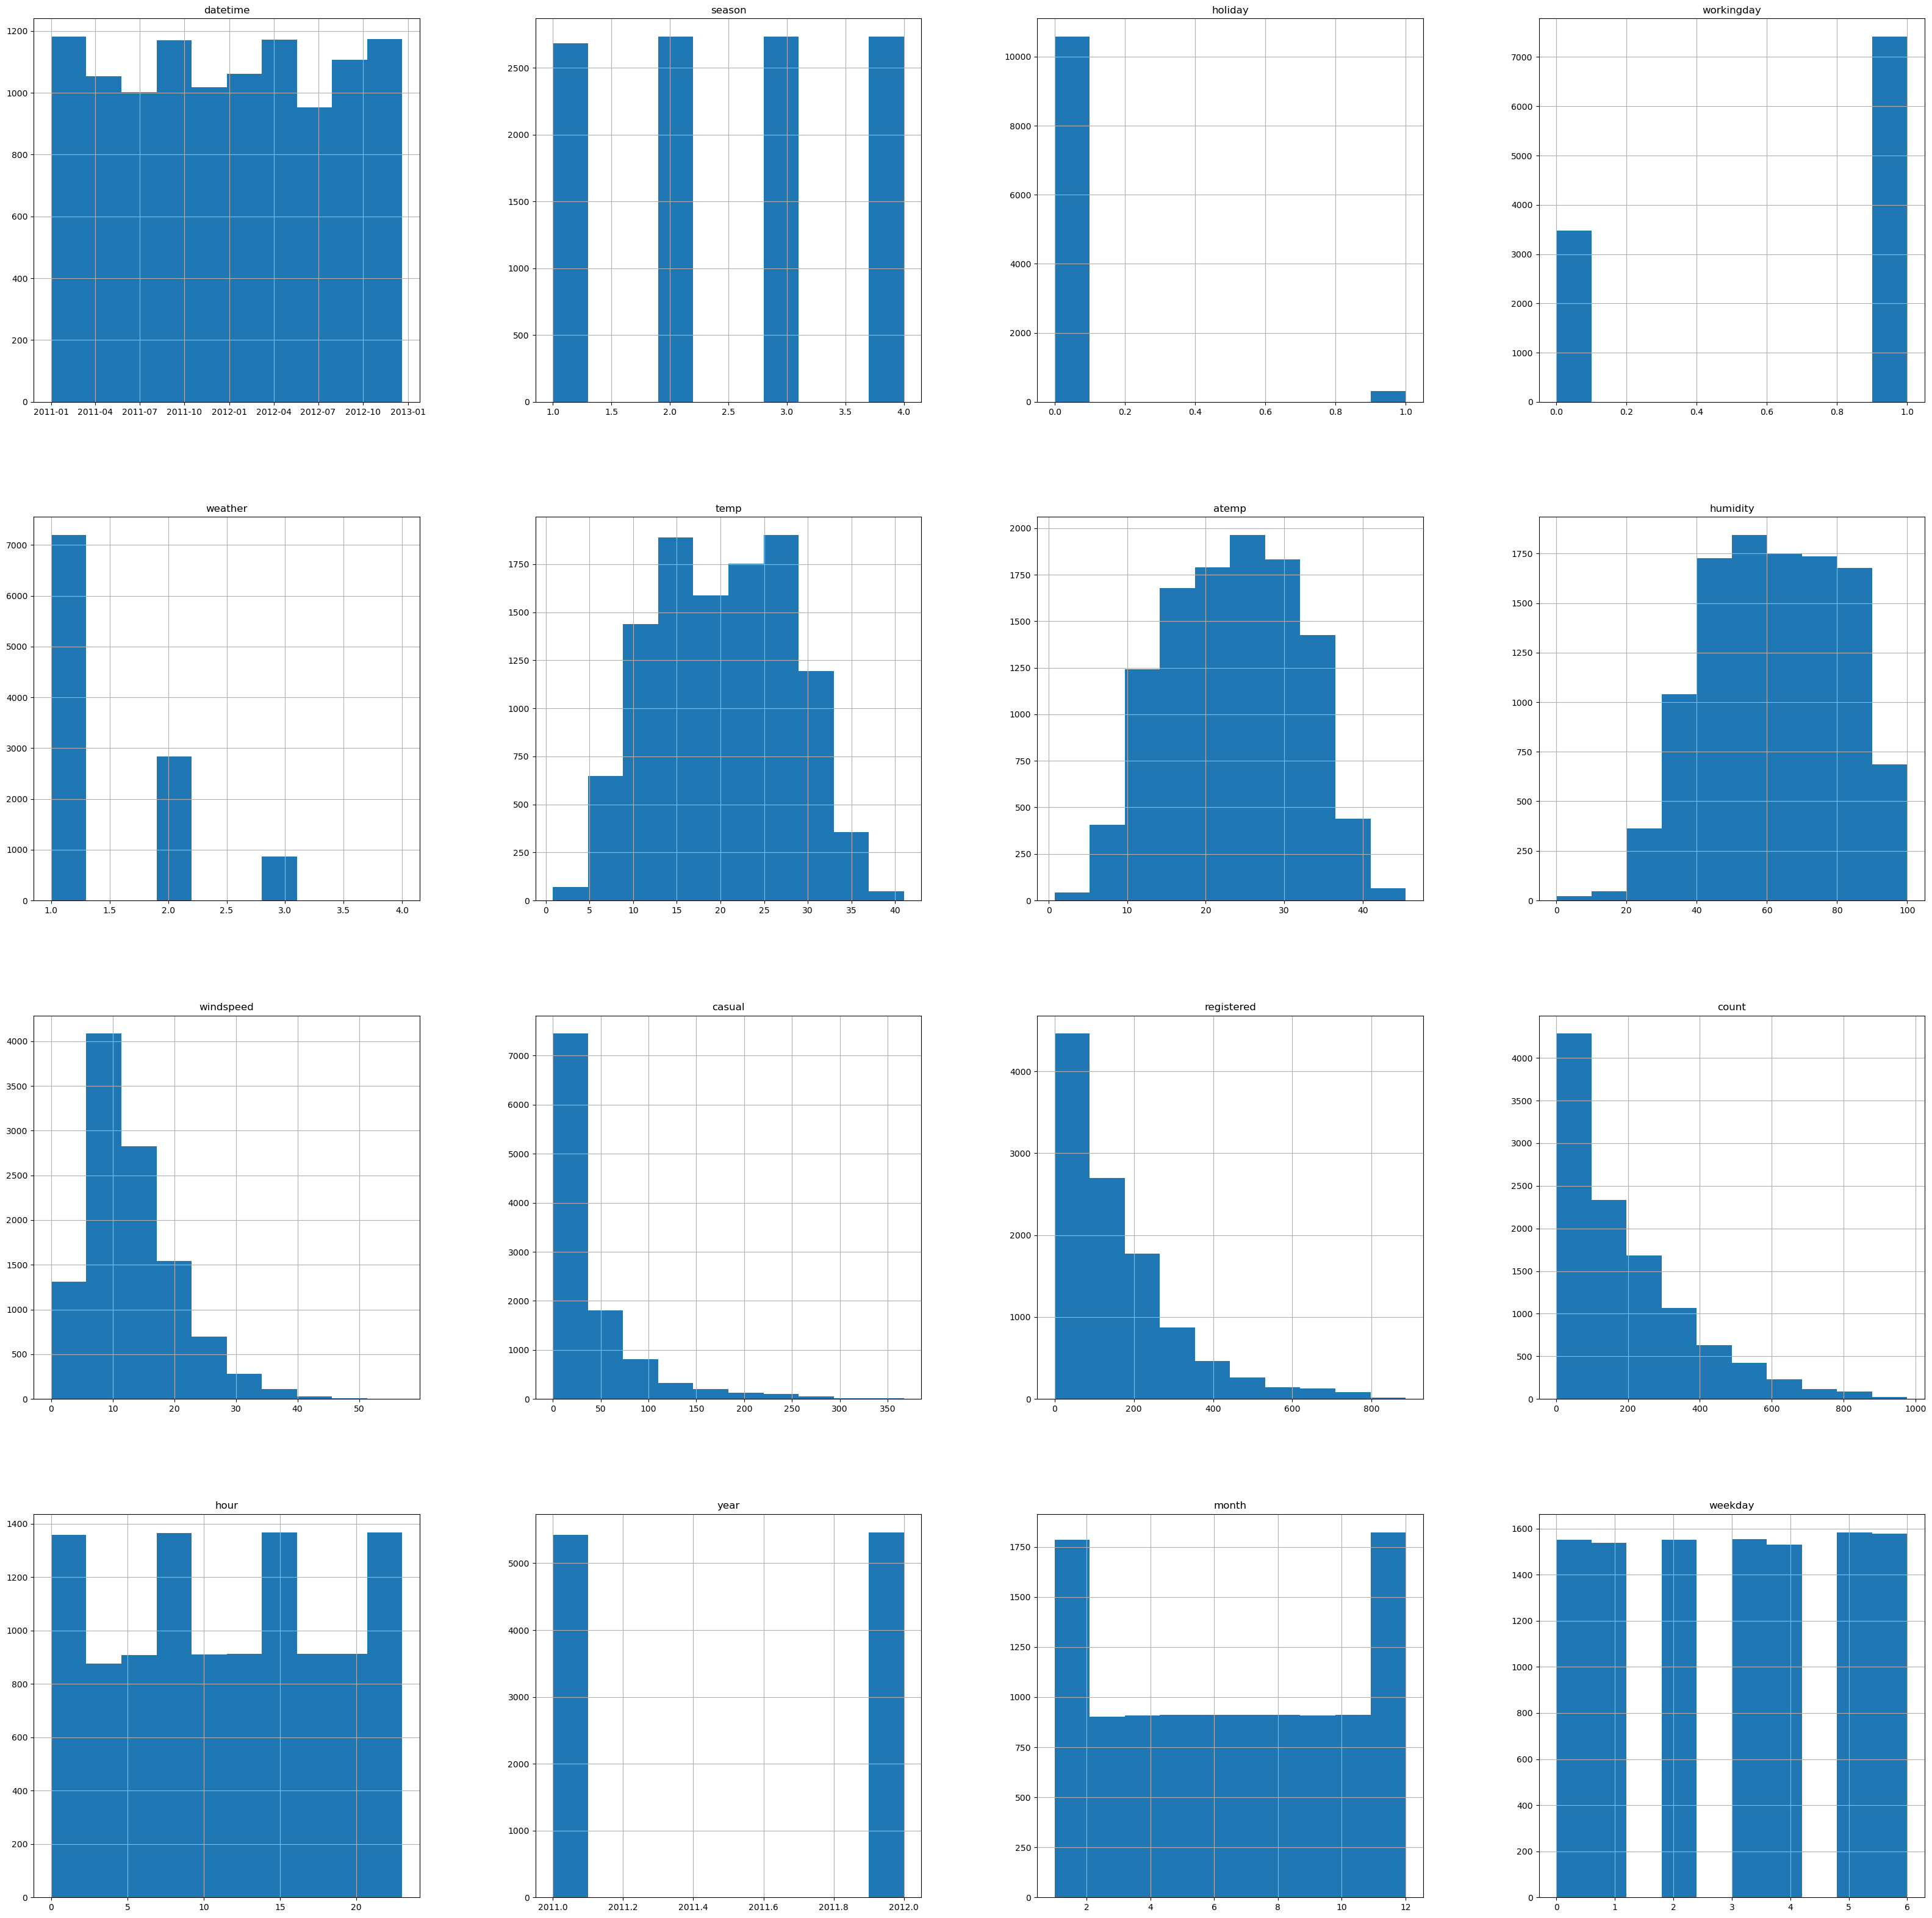

In [10]:
'''
Ploting to see the distribution of the features and better understand if they are balanced, normal distributed, etc.
'''

df.hist();

[Text(0.5, 0, 'Weather'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Count by Weather')]

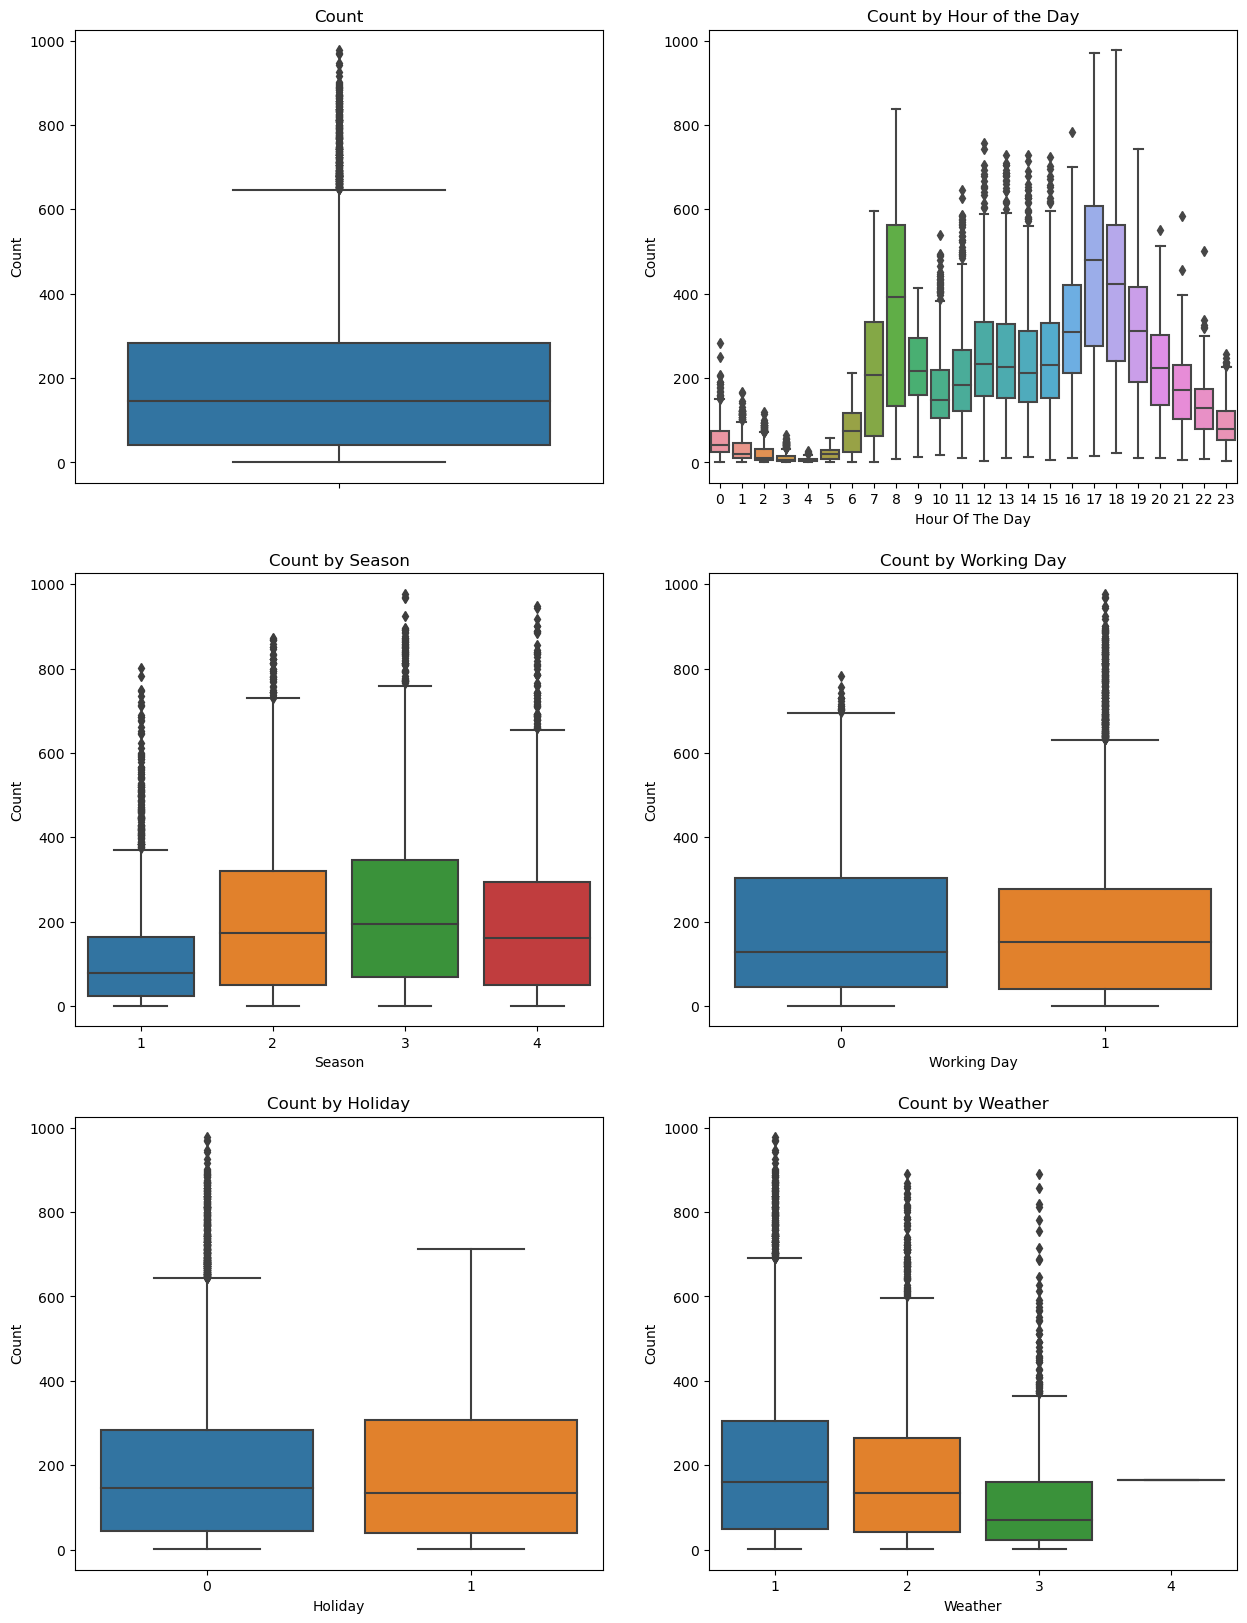

In [11]:
'''
Now we need to understand if we have outliers in our features and target. The best way to visualize it is trhough the
boxplot. 

'''

fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 20)
sns.boxplot(data=df,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=df,y="count",x="hour",orient="v",ax=axes[0][1])
sns.boxplot(data=df,y="count",x="season",orient="v",ax=axes[1][0])
sns.boxplot(data=df,y="count",x="workingday",orient="v",ax=axes[1][1])
sns.boxplot(data=df,y="count",x="holiday",orient="v",ax=axes[2][0])
sns.boxplot(data=df,y="count",x="weather",orient="v",ax=axes[2][1])

axes[0][0].set(ylabel='Count',title="Count")
axes[0][1].set(xlabel='Hour Of The Day', ylabel='Count',title="Count by Hour of the Day")
axes[1][0].set(xlabel='Season', ylabel='Count',title="Count by Season")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Count by Working Day")
axes[2][0].set(xlabel='Holiday', ylabel='Count',title="Count by Holiday")
axes[2][1].set(xlabel='Weather', ylabel='Count',title="Count by Weather")

We can see that we have some outliers in the count (target) feature. They seemed a really small portion of the data but have a value 3 or 4 times bigger than the normal values. So we must drop delete this outliers.

In [12]:
'''

Another form of feature selection is to see the correlation between the features. If the correlation is too strong than
we can drop one of them.
'''
corr_variables = df[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()

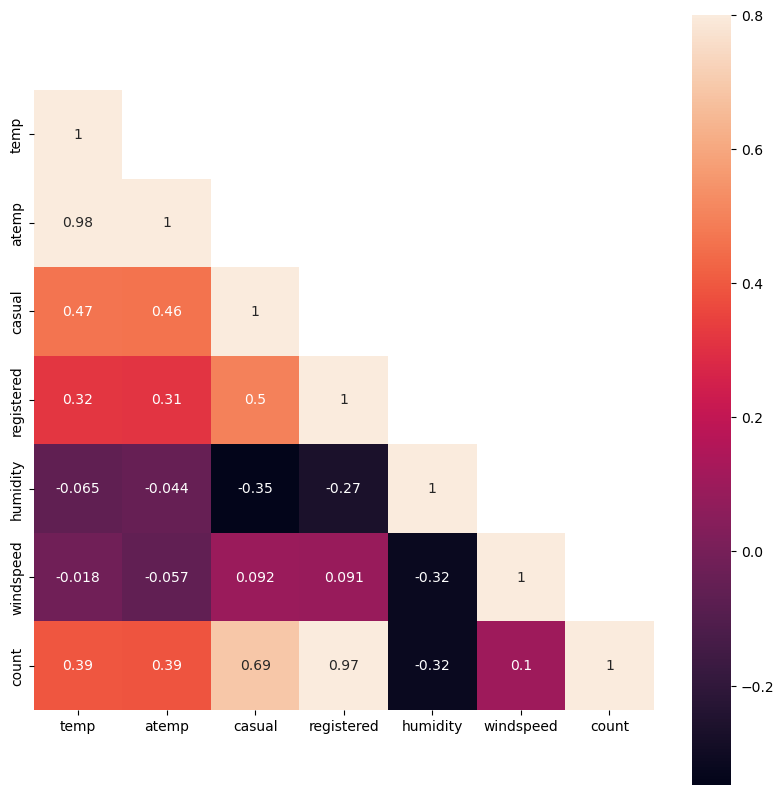

In [13]:
correlation_heatmap(corr_variables)

With the correlation plot we can see that <i>temp</i> and <i>atemp</i> are highly correlated wich could end in a multicolinearity problem. So, we understand that we must drop one of them.

In [14]:
for col in df.columns:
    print(df[col].value_counts())

datetime
2011-01-01 00:00:00    1
2012-05-01 21:00:00    1
2012-05-01 13:00:00    1
2012-05-01 14:00:00    1
2012-05-01 15:00:00    1
                      ..
2011-09-02 04:00:00    1
2011-09-02 05:00:00    1
2011-09-02 06:00:00    1
2011-09-02 07:00:00    1
2012-12-19 23:00:00    1
Name: count, Length: 10886, dtype: int64
season
4    2734
2    2733
3    2733
1    2686
Name: count, dtype: int64
holiday
0    10575
1      311
Name: count, dtype: int64
workingday
1    7412
0    3474
Name: count, dtype: int64
weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64
temp
14.76    467
26.24    453
28.70    427
13.94    413
18.86    406
22.14    403
25.42    403
16.40    400
22.96    395
27.06    394
24.60    390
12.30    385
21.32    362
17.22    356
13.12    356
29.52    353
10.66    332
18.04    328
20.50    327
30.34    299
9.84     294
15.58    255
9.02     248
31.16    242
8.20     229
27.88    224
23.78    203
32.80    202
11.48    181
19.68    170
6.56     146
33.62  

Looking to the <i>info()</i> we get the idea that we don't have null values, but we needed to investigate a little further because the null values can manifest in other forms that not tha NA one, like '-', 'none', '.', or even 0. Talking about zeros values, we understand that all the 0.0000 in widspeed are null values. In this case we have 4 options:

1 - **Drop the column**. But we have more than 80% of the column with values that are not zero, as we don't want to loose the information of this column, we won't drop it.

2 - **Drop the rows**. The number of zeros is not enough to make us consider to delete the column but are big enough for us to desconsider the dropping of all the rows that has the zero in the windspeed column.

3 - **Fill the Null values**. 

4 - **Predict the Null Values**.

In this case we will start with the most simple one (Fill the Null values), but if during the fine tunning fase we think we need a different aproach we can try the predict method.

### Preprocessing

1 - First we will delete the rows where we have the outliers in the target column (count).

2 - Second, we will replace the 0 values on the windspeed column for the median of the column.

3 - Defining the columns that we will use in the modeling process

4 - Train_test_split

In [15]:
#Deleting the outliers from the count column:
delete_outliers(df['count'], df)

Number of outliers deleted: 147
Shape of dataframe with Ouliers:  (10886, 16)
Shape of Dataframe After Deleting the Ouliers:  (10739, 16)


In [16]:
# Transforming the zero values into the median of the column:
# For df:
df['windspeed'].replace(0.0000, np.nan, inplace=True)
df['windspeed'].fillna(df['windspeed'].median(), inplace=True)

# For df_test:
df_test['windspeed'].replace(0.0000, np.nan, inplace=True)
df_test['windspeed'].fillna(df['windspeed'].median(), inplace=True)

In [17]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hour', 'year', 'month', 'weekday'],
      dtype='object')

In [18]:
# General df:
to_drop = ['datetime', 'atemp', 'casual', 'registered', 'count']
X = df.drop(to_drop, axis=1)

'''
As we saw in the hist() function before, our count variable is really skewed. In this case we should change it to log,
because taking the logarithm of the target variables can help normalize their distribution. Also, in some cases, the 
target variables may exhibit heteroscedasticity, meaning that the variance of the target values is not constant across 
the range of predictor variables. By applying a logarithmic transformation, the variance of the transformed target 
variables can become more stabilized, leading to better modeling results. Finally, transforming the target variables 
using the logarithm can help linearize relationships between the predictors and the targets. In some situations, the 
underlying relationship between the predictors and targets may be better represented by a linear model when the targets 
are in logarithmic form.
'''
y = df['count'].apply(lambda x: np.log1p(x)).values

In [19]:
X_test = df_test.drop(['datetime', 'atemp'], axis=1)

In [20]:
# Split the dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=rs)

### Modeling / Fine Tunning

In [79]:
#Definning our models and the params that we will try for each of them:
model_lbls = ['linear' # Linear Regression
             ,'xgb' # XGBoost
             ,'rf' # Random Forest
             ,'gbt' # Gradient Boost Tree
            ]

models = {
    'linear': {'name': 'Linear Regression',
           'estimator': LinearRegression(), 
           'param': [{'n_jobs': [None, -1]
          }]},
    
    'xgb':{'name': 'XGBoost',
           'estimator': xgb.XGBRegressor(random_state=rs),
           'param': [{'n_estimators':[50, 75, 100, 125, 200],
                     'learning_rate':[0.01, 0.05, 0.1, 0.5],
                     'n_jobs': [-1]
          }]},
    
    'rf': {'name': 'Random Forest',
           'estimator': RandomForestRegressor(random_state=rs),
           'param': [{'max_depth': [*range(3, 11)]
                     ,'n_estimators':[*range(10,60,10)]
                     ,'min_samples_leaf': [*range(1,10)]
          }]}, 
    'gbt':{'name': 'Gradient Boost Tree',
           'estimator': GradientBoostingRegressor(random_state=rs),
           'param': [{'learning_rate':[0.005, 0.01, 0.05, 0.1]
                     ,'max_depth': [*range(3, 11)]
                     ,'n_estimators':[*range(80,150,10)]
                     ,'min_samples_leaf': [*range(1,10)]
          }]}
}

In [80]:
scorings = ['neg_mean_squared_log_error']

In [85]:
# Running a GridSearch for each model and each different combination of params:
clfs = []
my_models = pd.DataFrame(columns=['scoring','model','best_params','rmsle'])
for model in model_lbls:
    for scoring in scorings:
        clf = RandomizedSearchCV(models[model]['estimator'], models[model]['param'], cv=cv,
                           scoring = scoring, n_jobs=-1, n_iter=200, verbose=2
                           )
        # Appending the clfs list with each clf fit
        clf.fit(X_train, y_train)
        clfs.append(clf)
        
        # creating the accuracy variable
        y_pred = clf.predict(X_val)        
        
        #cr = classification_report(y_val,y_pred, output_dict=True)
        
        # Creating the rmse variable
        RMSLE = rmsle(y_val, y_pred)

        best_params = clf.best_params_
        
        #Appending the dataset row by row
        row = [scoring, model, best_params, RMSLE]
        my_models.loc[len(my_models)] = row
        

C:\Users\joaov\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=200. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\joaov\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 20 is smaller than n_iter=200. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\joaov\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [-0.33724561 -0.1803572  -0.10264739 -0.06173653 -0.01873934 -0.01132129
 -0.00763712 -0.00706339 -0.0068135  -0.00655163 -0.00699263 -0.00667448
 -0.00656222 -0.00651319 -0.00651222         nan         nan         nan
         nan         nan]
  warnings.warn(


Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits


In [86]:
my_models

,scoring,model,best_params,rmsle
0,neg_mean_squared_log_error,linear,{'n_jobs': None},0.223075
1,neg_mean_squared_log_error,xgb,"{'n_jobs': -1, 'n_estimators': 200, 'learning_...",0.076793
2,neg_mean_squared_log_error,rf,"{'n_estimators': 50, 'min_samples_leaf': 1, 'm...",0.080305
3,neg_mean_squared_log_error,gbt,"{'n_estimators': 110, 'min_samples_leaf': 9, '...",0.075299


In [89]:
# Getting the paramters:
my_models['best_params'].iloc[3]

{'n_estimators': 110,
 'min_samples_leaf': 9,
 'max_depth': 6,
 'learning_rate': 0.1}

As we can see the best model is the **<i>Gradient Boost Tree</i>** with the lower RMSLE of 0.075.

### Best model


In [92]:
# model
best_model = GradientBoostingRegressor(n_estimators= 110,
                                 min_samples_leaf= 9,
                                 max_depth= 6,
                                 learning_rate=0.1,
                                 random_state=rs)

# Train the model
best_model.fit(X_train, y_train)


# Our Final Prediction on the test set
prediction = best_model.predict(X_test)  
prediction = np.expm1(prediction)

In [96]:
final_prediction = pd.DataFrame({'datetime':df_test['datetime'], 'count':prediction})